## Phase - 4: Iterative Feature Reduction and Selection

**Motive:**
    
Before working on this phase, please practice "Activity 10" in the 'Neural networks using Tensorflow' crash course (see nn-tf tab). The key activity in this phase is to study the importance of the input features by iteratively removing them. In other words, you can first train various models with only one feature at a time to learn how predictive each feature is. Once the significance of each feature is known, you can remove the most unimportant feature (i.e., remove the column), retrain the model, and observe the accuracy. You can iteratively repeat the process removing more and more unimportant features. The overall objective is to identify non-informative input features and remove them from the dataset. Finally, you can compare your feature-reduced model with the original model with all input features and discuss the difference in accuracy. Here is an example report.

### Approach

This notebook contains two important steps performed as part of this phase-4

    Step - 1: Get model stats with single feature 
    Step - 2: Get model stats with Important features
    Step - 3: Compare model with all features vs model with important features

#### Categorical Columns

'protocol_type', 'service', 'flag', 'land', 'logged_in', 'is_host_login', 'is_guest_login'

In [1]:
catg_cols = ['protocol_type', 'service', 'flag', 'land', 'logged_in', 'is_host_login', 'is_guest_login']

#### Continuous Columns

In [2]:
cont_cols = [ 'duration', 'src_bytes', 'dst_bytes', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate']

In [3]:
target_variable = 'label'

#### Data Load

In [4]:
import pandas as pd
df = pd.read_csv("../datasets/kddcup99_csv.csv")

#### Dataset size

In [5]:
df.shape

(494020, 42)

494020 records with 41 features and 1 target variable ("label") for prediction

In [6]:
df.head(2)

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,tcp,http,SF,181,5450,0,0,0,0,...,9,1.0,0.0,0.11,0.0,0.0,0.0,0.0,0.0,normal
1,0,tcp,http,SF,239,486,0,0,0,0,...,19,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,normal


As seen above, there are various type of malware attacks which can be grouped as "abnormal" to make this problem as binary classification problem

##### Group all malware attacks as "abnormal"

In [7]:
attack_types = list(df['label'].unique())
attack_types.remove('normal') # remove normal from attack types as we only want malware attacks to convert as abnormal

In [8]:
df['label'] = df['label'].replace(attack_types, 'abnormal')
df.shape

(494020, 42)

In [9]:
# both these columns have all values as 0, hence not useful for our experiments
df.drop(columns=['is_host_login'], inplace=True)
df.drop(columns=['num_outbound_cmds'], inplace=True)
catg_cols.remove('is_host_login')
cont_cols.remove('num_outbound_cmds')

In [10]:
df['label'].value_counts()

abnormal    396743
normal       97277
Name: label, dtype: int64

In [11]:
# Transform Target Binary label to 0 and 1
df['label'] = df['label'].map({'normal': 1, 'abnormal': 0})
df['label'].value_counts()

0    396743
1     97277
Name: label, dtype: int64

In [12]:
for cat_col in catg_cols:
    df[cat_col] = df[cat_col].astype(str)

### Step - 1 Iterative Feature Reduction

**Note: Automated model building with different feature inputs by wrapping the steps in to a function (can be extended as a framework)**

In [97]:
from keras.utils.vis_utils import plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

def _convert_categorical_to_one_hot_encoding(dataset, column_name):
    dummy_values = pd.get_dummies(dataset[column_name])
    #print("dummy_values", dummy_values.shape[1])
    for category in dummy_values.columns:
        dummy_value_name = f"{column_name}-{category}"
        dataset[dummy_value_name] = dummy_values[category]
    dataset.drop(column_name, axis=1, inplace=True)
    return dataset

def build_best_model_from_previous_phase(XTRAIN, YTRAIN,XVALID,YVALID):
    best_model_selected = Sequential()
    best_model_selected.add(Dense(4, input_dim = len(XTRAIN[0, :]), activation='relu'))
    best_model_selected.add(Dense(1, activation='sigmoid'))
    best_model_selected.compile(loss='binary_crossentropy', optimizer = 'rmsprop', metrics=[ 'accuracy'])
    best_model_selected_history = best_model_selected.fit(XTRAIN, YTRAIN, validation_data = (XVALID, YVALID), 
                                            batch_size=256, epochs =8, verbose = 0)
    return best_model_selected, best_model_selected_history
    
def get_model_accuracy_with_single_input(input_df, input_feature: str):
    
    if input_df.shape[1] != 2:
        raise Exception("Expected single feature input dataset")
    
    if input_feature in catg_cols:
        print(f"Single input feature is categorical and is : {input_feature}")
        input_df = _convert_categorical_to_one_hot_encoding(input_df, input_feature)
    else:
        print(f"Single input feature is continous and is {input_feature}")
        df_CONTCOLS_MIN = input_df[[input_feature]].min(axis=0)
        df_CONTCOLS_MAX = input_df[[input_feature]].max(axis=0)
        input_df[[input_feature]] = (input_df[[input_feature]] - df_CONTCOLS_MIN) / (df_CONTCOLS_MAX - df_CONTCOLS_MIN)
    
    if input_df.isna().values.any() is False:
        raise Exception("Cannot proceed with modeling with null values")
    
    print(input_df.shape)
    input_df = input_df.sample(frac=1).reset_index(drop=True)
    X_numpy = input_df.drop(columns=['label']).to_numpy()
    Y_numpy = input_df['label'].to_numpy()
    print(X_numpy.shape, Y_numpy.shape)
    
    # Split into training and validation, 20% validation set and 80% training 
    index_20percent = int(0.2 * len(input_df.to_numpy()[:, 0]))
    print(index_20percent)
    XVALID = X_numpy[:index_20percent]
    YVALID = Y_numpy[:index_20percent]
    XTRAIN = X_numpy[index_20percent:]
    YTRAIN = Y_numpy[index_20percent:]
    best_model_selected, best_model_selected_history = build_best_model_from_previous_phase(XTRAIN, YTRAIN,XVALID,YVALID)
    return best_model_selected, best_model_selected_history
    


In [15]:
single_column_accuracy_stats = {}
all_cols = catg_cols + cont_cols
for single_feature in all_cols:
    
    model_object, model_selected_history = get_model_accuracy_with_single_input(df[[single_feature, 'label']], single_feature)
    single_column_accuracy_stats[single_feature] = model_selected_history.history['val_accuracy'][-1]

Single input feature is categorical and is : protocol_type
(494020, 4)


<ipython-input-14-71a653019e96>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[dummy_value_name] = dummy_values[category]
C:\Users\PepsiHomeUser\anaconda3\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


(494020, 3) (494020,)
98804
Single input feature is categorical and is : service
(494020, 67)
(494020, 66) (494020,)
98804
Single input feature is categorical and is : flag
(494020, 12)
(494020, 11) (494020,)
98804
Single input feature is categorical and is : land
(494020, 3)
(494020, 2) (494020,)
98804
Single input feature is categorical and is : logged_in
(494020, 3)
(494020, 2) (494020,)
98804
Single input feature is categorical and is : is_guest_login
(494020, 3)
(494020, 2) (494020,)
98804
Single input feature is continous and is duration
(494020, 2)


C:\Users\PepsiHomeUser\anaconda3\lib\site-packages\pandas\core\frame.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


(494020, 1) (494020,)
98804
Single input feature is continous and is src_bytes
(494020, 2)
(494020, 1) (494020,)
98804
Single input feature is continous and is dst_bytes
(494020, 2)
(494020, 1) (494020,)
98804
Single input feature is continous and is wrong_fragment
(494020, 2)
(494020, 1) (494020,)
98804
Single input feature is continous and is urgent
(494020, 2)
(494020, 1) (494020,)
98804
Single input feature is continous and is hot
(494020, 2)
(494020, 1) (494020,)
98804
Single input feature is continous and is num_failed_logins
(494020, 2)
(494020, 1) (494020,)
98804
Single input feature is continous and is num_compromised
(494020, 2)
(494020, 1) (494020,)
98804
Single input feature is continous and is root_shell
(494020, 2)
(494020, 1) (494020,)
98804
Single input feature is continous and is su_attempted
(494020, 2)
(494020, 1) (494020,)
98804
Single input feature is continous and is num_root
(494020, 2)
(494020, 1) (494020,)
98804
Single input feature is continous and is num_file

**Note: Removed verbose to avoid spamming with logs in this notebook which makes this notebook super lengthy**

Text(0.5, 1.0, 'Validation Accuracy of Single Input Features')

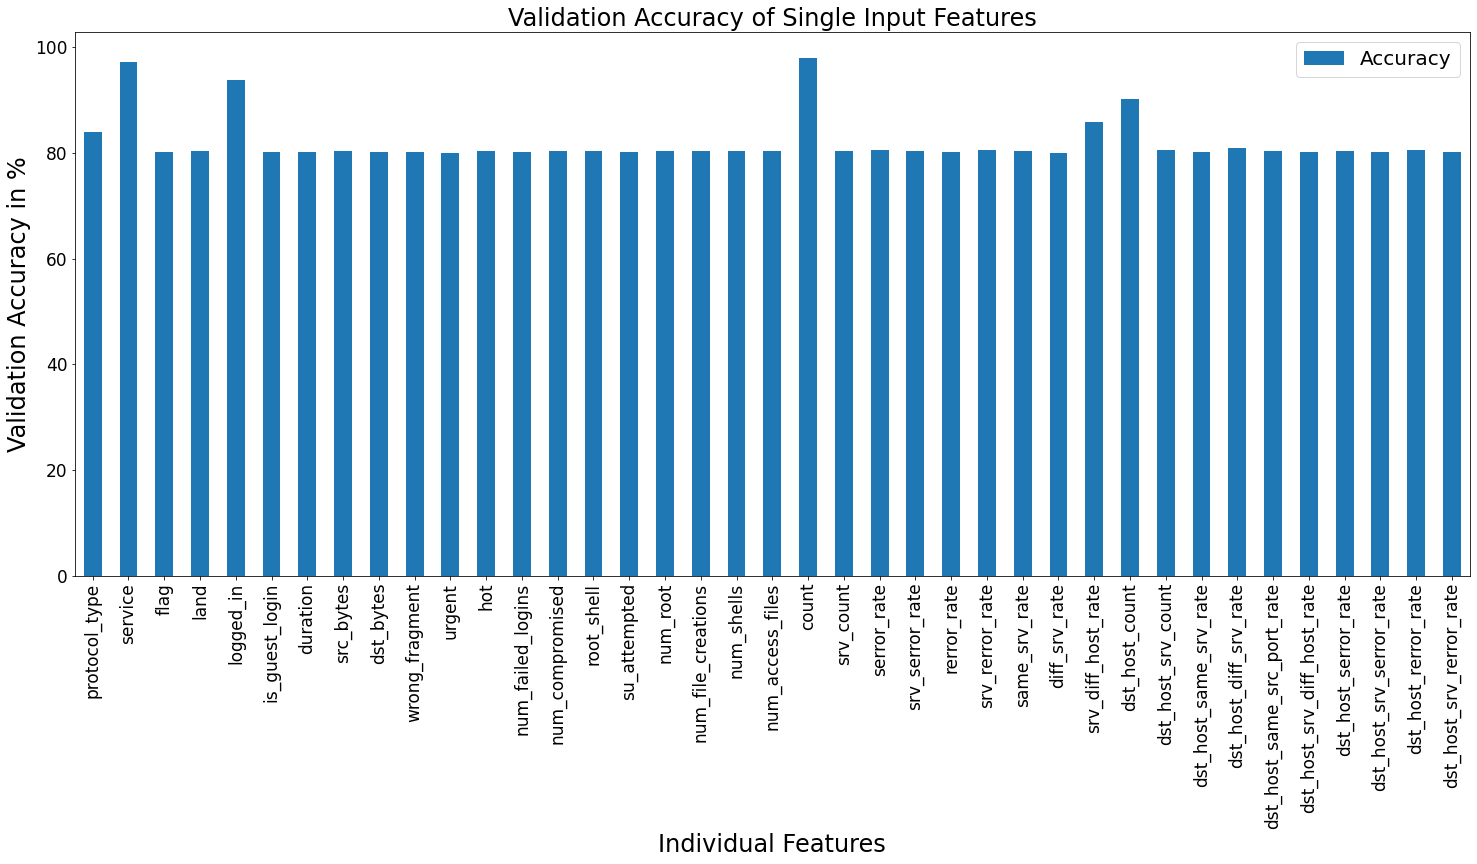

In [49]:
import pandas as pd


single_column_accuracy_stats_df = pd.DataFrame.from_dict(single_column_accuracy_stats, orient='index', columns=['Accuracy'])
single_column_accuracy_stats_df['Accuracy'] = single_column_accuracy_stats_df.apply(lambda row: row['Accuracy'] * 100, axis=1)
ax1 = single_column_accuracy_stats_df.plot.bar(figsize=(25,10), ylabel='Accuracy', rot=90, fontsize=17)
ax1.set_xlabel('Individual Features',fontdict={'fontsize':24})
ax1.set_ylabel('Validation Accuracy in %',fontdict={'fontsize':24})
ax1.legend(fontsize=20)
ax1.set_title("Validation Accuracy of Single Input Features", fontsize=24)

In [18]:
single_column_accuracy_stats_df.to_csv("single_column_accuracy_stats_df.csv", index=False)

In [52]:
sorted_single_column_accuracy_stats_df = single_column_accuracy_stats_df.sort_values(by='Accuracy')
sorted_single_column_accuracy_stats_df['feature_name'] = sorted_single_column_accuracy_stats_df.index
sorted_single_column_accuracy_stats_df.reset_index(inplace=True)
sorted_single_column_accuracy_stats_df.drop(columns=['index'], inplace=True)
sorted_single_column_accuracy_stats_df

,Accuracy,feature_name
0,79.959315,diff_srv_rate
1,80.054450,urgent
2,80.109107,dst_host_srv_diff_host_rate
3,80.175906,dst_host_same_srv_rate
4,80.178940,su_attempted
5,80.182987,duration
6,80.184001,is_guest_login
7,80.204242,flag
8,80.215377,dst_host_srv_serror_rate
9,80.223471,num_failed_logins


**Inference of Step -1:**

- In this step, we obtained performance of the models built with each individual feature.
- We ranked the models as per the validation accuracy. The better the accuracy the higher the rank.
- As seen in the above sorted dataframe that the feature "count" has the highest importance and the feature "diff_srv_rate" has the least importance

### Step - 2 Remove unimportant features and get the accuracy

Note: Wrote another function automate the model building with various sets of input features

In [60]:
def get_model_accuracy_with_one_or_more_multiple_inputs(input_df, input_features: str, continous_columns):
    
    # handle categorical if any
    for ip_feat in input_features:
        if ip_feat in catg_cols:
            input_df = _convert_categorical_to_one_hot_encoding(input_df, ip_feat)
    
    if len(continous_columns) > 0:
    
        df_CONTCOLS_MIN = input_df[continous_columns].min(axis=0)
        df_CONTCOLS_MAX = input_df[continous_columns].max(axis=0)
        input_df[continous_columns] = (input_df[continous_columns] - df_CONTCOLS_MIN) / (df_CONTCOLS_MAX - df_CONTCOLS_MIN)
    
    if input_df.isna().values.any() is False:
        raise Exception("Cannot proceed with modeling with null values")
    
    print(input_df.shape)
    input_df = input_df.sample(frac=1).reset_index(drop=True)
    X_numpy = input_df.drop(columns=['label']).to_numpy()
    Y_numpy = input_df['label'].to_numpy()
    print(X_numpy.shape, Y_numpy.shape)
    
    # Split into training and validation, 20% validation set and 80% training 
    index_20percent = int(0.2 * len(input_df.to_numpy()[:, 0]))
    print(index_20percent)
    XVALID = X_numpy[:index_20percent]
    YVALID = Y_numpy[:index_20percent]
    XTRAIN = X_numpy[index_20percent:]
    YTRAIN = Y_numpy[index_20percent:]
    best_model_selected, best_model_selected_history = build_best_model_from_previous_phase(XTRAIN, YTRAIN,XVALID,YVALID)
    return best_model_selected, best_model_selected_history

In [61]:
sorted_single_column_accuracy_stats_df.shape

(39, 2)

In [62]:
iterative_feature_removal_stats = {}

for idx, row in sorted_single_column_accuracy_stats_df.iterrows():
    features_to_remove = sorted_single_column_accuracy_stats_df[:idx]['feature_name'].tolist()
    n_features_to_remove = len(features_to_remove)
    print("N features removed: ", n_features_to_remove)
    # remove features from categorical column and continous columns
    new_cat_cols = []
    for cat_col in catg_cols:
        if cat_col not in features_to_remove:
            new_cat_cols.append(cat_col)
    
    new_cont_cols = []
    for cont_col in cont_cols:
        if cont_col not in features_to_remove:
            new_cont_cols.append(cont_col)
    
    new_columns = new_cat_cols + new_cont_cols + ['label']
    model_object, model_selected_history = get_model_accuracy_with_one_or_more_multiple_inputs(df[new_columns],
                                                                                new_columns, new_cont_cols)
    
    
    iterative_feature_removal_stats[f"{n_features_to_remove} removed features"] = model_selected_history.history['val_accuracy'][-1]


N features removed:  0


<ipython-input-14-71a653019e96>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[dummy_value_name] = dummy_values[category]
C:\Users\PepsiHomeUser\anaconda3\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
C:\Users\PepsiHomeUser\anaconda3\lib\site-packages\pandas\core\frame.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/

(494020, 120)
(494020, 119) (494020,)
98804
N features removed:  1
(494020, 119)
(494020, 118) (494020,)
98804
N features removed:  2
(494020, 118)
(494020, 117) (494020,)
98804
N features removed:  3
(494020, 117)
(494020, 116) (494020,)
98804
N features removed:  4
(494020, 116)
(494020, 115) (494020,)
98804
N features removed:  5
(494020, 115)
(494020, 114) (494020,)
98804
N features removed:  6
(494020, 114)
(494020, 113) (494020,)
98804
N features removed:  7
(494020, 112)
(494020, 111) (494020,)
98804
N features removed:  8
(494020, 101)
(494020, 100) (494020,)
98804
N features removed:  9
(494020, 100)
(494020, 99) (494020,)
98804
N features removed:  10
(494020, 99)
(494020, 98) (494020,)
98804
N features removed:  11
(494020, 98)
(494020, 97) (494020,)
98804
N features removed:  12
(494020, 97)
(494020, 96) (494020,)
98804
N features removed:  13
(494020, 96)
(494020, 95) (494020,)
98804
N features removed:  14
(494020, 95)
(494020, 94) (494020,)
98804
N features removed:  15


In [77]:
iterative_feature_removal_stats_df

,Accuracy
0 removed features,99.798590
1 removed features,99.813771
2 removed features,99.752033
3 removed features,99.806690
4 removed features,99.423099
5 removed features,99.456501
6 removed features,99.564797
7 removed features,99.487877
8 removed features,99.795556
9 removed features,99.737865


Text(0.5, 1.0, 'Validation Accuracy after removing N less important features')

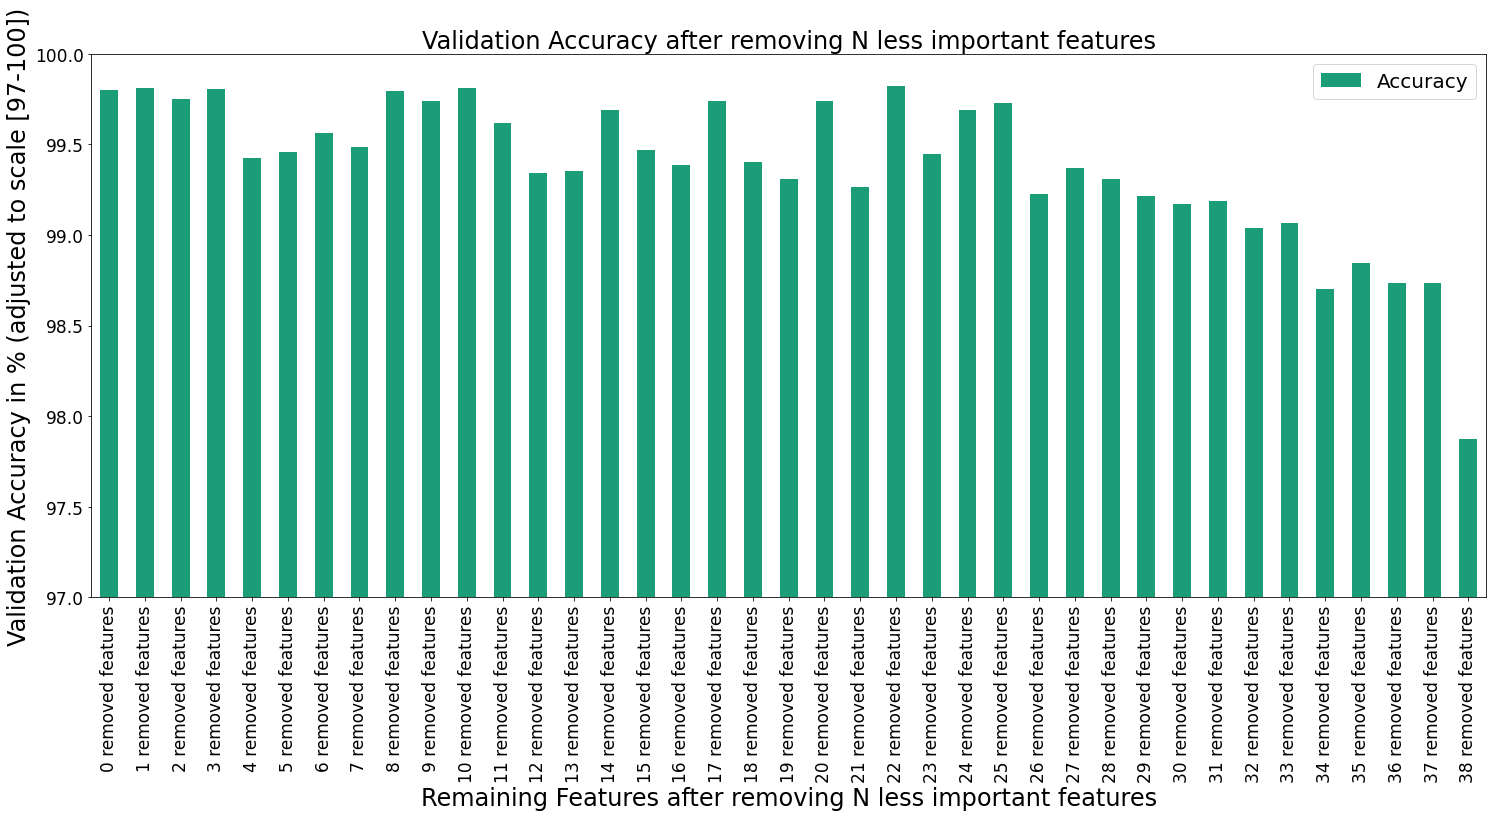

In [80]:
iterative_feature_removal_stats_df = pd.DataFrame.from_dict(iterative_feature_removal_stats, orient='index', columns=['Accuracy'])
iterative_feature_removal_stats_df['Accuracy'] = iterative_feature_removal_stats_df.apply(lambda row: row['Accuracy'] * 100, axis=1)
ax1 = iterative_feature_removal_stats_df.plot.bar(figsize=(25,10), ylabel='Accuracy', rot=90, fontsize=17, colormap='Dark2')
ax1.set_xlabel('Remaining Features after removing N less important features',fontdict={'fontsize':24})
ax1.set_ylabel('Validation Accuracy in % (adjusted to scale [97-100])',fontdict={'fontsize':24})
ax1.legend(fontsize=20)
ax1.set_ylim([97,100])
ax1.set_title("Validation Accuracy after removing N less important features", fontsize=24)

**Step-2 Inference:**

- As seen in the above graph, the first dip in the model perfomance happened when 4 features are removed. However, we need to find the best possible set of features
- The best possible set of features can be obtained from the above graph where we have to find the minimal set of features that resulted in the best valdiation accuracy.
- From the above graph, the when 22 features low importance features are removed, we have seen the highest validation accuracy.
- Therefore, we will build the model after removing 22 low importance features and compare it with the model with all features

### Step -3: Performance Comparision: All Features Model vs Important Features Model

In [115]:
final_features_selected = sorted_single_column_accuracy_stats_df[23:]['feature_name'].tolist()
imp_features_cat = []
for cat_col in catg_cols:
    if cat_col in final_features_selected:
        imp_features_cat.append(cat_col)
    
imp_features_cont = []
for cont_col in cont_cols:
    if cont_col in final_features_selected:
        imp_features_cont.append(cont_col)
    
imp_features = imp_features_cat + imp_features_cont + ['label']
imp_feat_model_object, imp_feat_model_selected_history = get_model_accuracy_with_one_or_more_multiple_inputs(df[imp_features],
                                                                                imp_features, imp_features_cont)
imp_feat_model_selected_history.history['val_accuracy'][-1]

<ipython-input-97-1fab71a15beb>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[dummy_value_name] = dummy_values[category]


(494020, 85)
(494020, 84) (494020,)
98804


0.9984413385391235

In [99]:
all_features = catg_cols + cont_cols + ["label"]
all_feat_model_object, all_feat_model_selected_history = get_model_accuracy_with_one_or_more_multiple_inputs(df[all_features],
                                                                                all_features, cont_cols)
all_feat_model_selected_history.history['val_accuracy'][-1]

<ipython-input-97-1fab71a15beb>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[dummy_value_name] = dummy_values[category]


(494020, 120)
(494020, 119) (494020,)
98804


0.9926318526268005

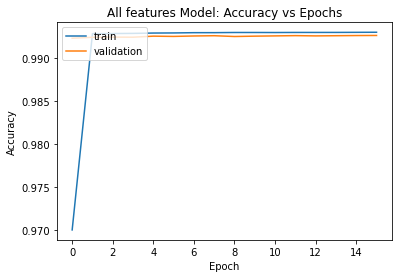

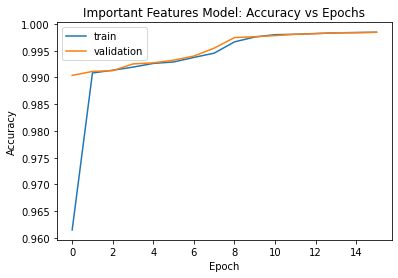

In [116]:
import matplotlib.pyplot as plt

plt.plot(all_feat_model_selected_history.history['accuracy'])
plt.plot(all_feat_model_selected_history.history['val_accuracy'])
plt.title('All features Model: Accuracy vs Epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


plt.plot(imp_feat_model_selected_history.history['accuracy'])
plt.plot(imp_feat_model_selected_history.history['val_accuracy'])
plt.title('Important Features Model: Accuracy vs Epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

**Step - 3 Inference**
- The learning rate of the all features model did not change after second epoch.
- However, the importance feature model had a constan learning rate over the epochs which is promising.
- Moreover, we have obtained better metric results (accuracy) with the importance features model.
- Also, modeling time of the importance features model is faster than the all features model as the compuations are lesser with lesser number of features. Morever, it is a save in terms of computing cost and modeling time.

**Conclusion:**

In [117]:
final_features_selected

['num_access_files',
 'src_bytes',
 'num_compromised',
 'dst_host_same_src_port_rate',
 'hot',
 'srv_rerror_rate',
 'dst_host_srv_count',
 'serror_rate',
 'dst_host_rerror_rate',
 'dst_host_diff_srv_rate',
 'protocol_type',
 'srv_diff_host_rate',
 'dst_host_count',
 'logged_in',
 'service',
 'count']

The above list of features are derived as importance ones for this dataset using iterative feature reduction technique.